In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

Using cuDNN version 5105 on context None
Mapped name None to device cuda0: GeForce GTX 1080 (0000:01:00.0)


In [2]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [3]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl'))
#for example, 10th class is ostrich:
print (classes[9])

ostrich, Struthio camelus


You have to implement two functions in the cell below.
Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [3]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224
def preprocess(img):
    img = img[:,:,(2,1,0)]
    img=img-MEAN_VALUES
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)


img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)
print(preprocess(img).dtype)
print (np.linalg.norm(deprocess(preprocess(img)) - img))

int64
0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [4]:
net = build_model()

In [6]:
import pickle
with open('vgg16.pkl','rb') as f:
    weights = pickle.load(f)
     
lasagne.layers.set_all_param_values(net['prob'], weights['param values'] )

In [7]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image)
prob = theano.function([input_image], output) 

### Sanity check
Давайте проверим, что загруженная сеть работает. Для этого мы скормим ей картину альбатроса и проверим, что она правильно его распознаёт

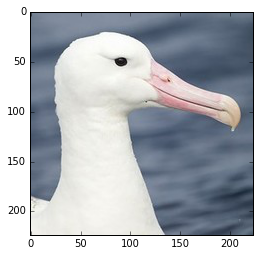

top-5 classes are:
0.999841	albatross
0.000159	goose
0.000000	white stork
0.000000	spoonbill
0.000000	oystercatcher


In [8]:
img = imread('albatross.jpg')
plt.imshow(img)
plt.show()


p = prob(preprocess(img).astype(np.float32))

labels = p.ravel().argsort()[-1:-6:-1]
print 'top-5 classes are:'
for l in labels:
    print '%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0])

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80% )

In [108]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

input_image = T.tensor4('input')
output_fc8 = lasagne.layers.get_output(net['fc8'], input_image)
feature = theano.function([input_image], output_fc8) 

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = feature(img.astype(np.float32))
    Y.append(y)
    X.append(features)



100%|██████████| 25000/25000 [05:06<00:00, 81.45it/s]


In [114]:
with open('feature_X.pkl','wb') as f:
    pickle.dump(X,f,pickle.HIGHEST_PROTOCOL)
with open ('feature_Y.pkl','wb') as g:
    pickle.dump(Y,g,pickle.HIGHEST_PROTOCOL)

In [9]:
X=pickle.load(open('feature_X.pkl','rb'))
Y=pickle.load(open('feature_Y.pkl','rb'))

In [10]:
X = np.concatenate(X) #stack all [1xfeature] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [11]:
from sklearn.cross_validation import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)
print(X_train.shape)

(20000, 1000)


/home/tigrann/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


#Random Forest
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train,Y_train)

#Extra Trees Classifier
etc=ExtraTreesClassifier(n_estimators=50)
etc.fit(X_train,Y_train)

# Gradient Boosting Classifier
gbc=GradientBoostingClassifier(n_estimators=50)
gbc.fit(X_train,Y_train)

#Ada Boost Classifier

abc=AdaBoostClassifier()
abc.fit(X_train,Y_train)

{'Random Forest accuracy': rf.score(X_test,Y_test),'Extra Trees Classifier accuracy': etc.score(X_test,Y_test),
'Gradient Boosting Classifier accuracy' : gbc.score(X_test,Y_test),
'Ada Boost Classifier accuracy': abc.score(X_test,Y_test)}


{'Ada Boost Classifier accuracy': 0.9728,
 'Extra Trees Classifier accuracy': 0.97240000000000004,
 'Gradient Boosting Classifier accuracy': 0.9738,
 'Random Forest accuracy': 0.97599999999999998}

In [42]:
#Logistic Regression and Ridge Classifier
lr=LogisticRegression()
lr.fit(X_train,Y_train)

rc=RidgeClassifier()
rc.fit(X_train,Y_train)
{'Logistic Regression accuracy':lr.score(X_test,Y_test),'Ridge Classifier accuracy':rc.score(X_test,Y_test)}

{'Logistic Regression accuracy': 0.97699999999999998,
 'Ridge Classifier accuracy': 0.98080000000000001}

In [43]:
#SVC and Decision Tree

svc=SVC()
svc.fit(X_train,Y_train)

dt=DecisionTreeClassifier()
dt.fit(X_train,Y_train)

{'SVC accuracy':svc.score(X_test,Y_test),'Decision Tree':dt.score(X_test,Y_test)}

{'Decision Tree': 0.95440000000000003, 'SVC accuracy': 0.95620000000000005}

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [5]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X1=[]
Y1=[]
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    X1.append(fname)
    Y1.append(y)
    
X1=np.array(X1)
Y1=np.array(Y1)

100%|██████████| 25000/25000 [00:00<00:00, 1532512.93it/s]


In [10]:
print(X1.shape,Y1.shape)

((25000,), (25000,))


In [6]:
from sklearn.cross_validation import train_test_split
X_tr,X_rest,Y_tr,Y_rest=train_test_split(X1,Y1,test_size=0.2)
X_val,X_t,Y_val,Y_t=train_test_split(X_rest,Y_rest,test_size=0.5)

/home/tigrann/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from copy import deepcopy 
new_net=deepcopy(net)
del new_net['prob'],new_net['fc8'],new_net['fc7_dropout']

In [8]:
new_net['elu']=DenseLayer(new_net['fc7'],100, nonlinearity=lasagne.nonlinearities.elu)
new_net['lin_drop']=DropoutLayer(new_net['elu'],p=0.5)
new_net['lin']=DenseLayer(new_net['lin_drop'],200, nonlinearity=lasagne.nonlinearities.linear)
new_net['smax']= NonlinearityLayer(new_net['lin'], softmax)

In [14]:
all_weights = lasagne.layers.get_all_params(new_net['smax'])
print all_weights

[W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b]


In [9]:
input_X = T.tensor4()
target_y = T.vector('vec',dtype='int32')

y_predicted = lasagne.layers.get_output(new_net['smax'],input_X)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

all_params = lasagne.layers.get_all_params(new_net['smax'],trainable=True)
old_params= lasagne.layers.get_all_params(new_net['fc7'],trainable=True)
new_params = [w for w in all_params if w not in old_params]

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.momentum(loss, new_params,learning_rate=0.01,momentum=0.9)

In [16]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [18]:
def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

In [18]:
X_tr.shape

(20000,)

In [10]:
import time

def train(num_epochs = 100,batch_size = 50):
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_tr, Y_tr,batch_size):
            inpt,targets = batch
            inputs=[]
            for fname in inpt:
                img = imread("train/"+fname)
                img = preprocess(imresize(img,(IMAGE_W,IMAGE_W))).astype(np.float32)
                inputs.append(img)
            inputs=np.concatenate(inputs)
            train_err_batch, train_acc_batch= train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, Y_val, batch_size):
            inpt,targets = batch
            inputs=[]
            for fname in inpt:
                img = imread("train/"+fname)
                img = preprocess(imresize(img,(IMAGE_W,IMAGE_W))).astype(np.float32)
                inputs.append(img)
            inputs=np.concatenate(inputs)
            
            val_acc += accuracy_fun(inputs, targets)
            val_batches += 1

    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

In [20]:
train(10,200)

Epoch 1 of 10 took 184.949s
  training loss (in-iteration):		0.259957
  train accuracy:		94.91 %
  validation accuracy:		96.75 %
Epoch 2 of 10 took 185.226s
  training loss (in-iteration):		0.078367
  train accuracy:		97.80 %
  validation accuracy:		97.54 %
Epoch 3 of 10 took 185.202s
  training loss (in-iteration):		0.061488
  train accuracy:		98.03 %
  validation accuracy:		97.46 %
Epoch 4 of 10 took 185.530s
  training loss (in-iteration):		0.048054
  train accuracy:		98.30 %
  validation accuracy:		97.67 %
Epoch 5 of 10 took 185.182s
  training loss (in-iteration):		0.044334
  train accuracy:		98.45 %
  validation accuracy:		97.83 %
Epoch 6 of 10 took 185.211s
  training loss (in-iteration):		0.042628
  train accuracy:		98.45 %
  validation accuracy:		97.71 %
Epoch 7 of 10 took 185.267s
  training loss (in-iteration):		0.038409
  train accuracy:		98.57 %
  validation accuracy:		98.12 %
Epoch 8 of 10 took 185.181s
  training loss (in-iteration):		0.036543
  train accuracy:		98.67 %


In [21]:
params=lasagne.layers.get_all_param_values(new_net['smax'])
with open('params2.pkl','wb') as f:
    pickle.dump(params,f,pickle.HIGHEST_PROTOCOL)

In [13]:
with open('params2.pkl','rb') as f:
    params=pickle.load(f)
lasagne.layers.set_all_param_values(new_net['smax'],params)


In [14]:
input_X = T.tensor4()
target_y = T.vector('vec',dtype='int32')

y_predicted = lasagne.layers.get_output(new_net['smax'],input_X)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

all_params = lasagne.layers.get_all_params(new_net['smax'],trainable=True)
old_params= lasagne.layers.get_all_params(new_net['fc7'],trainable=True)
new_params = [w for w in all_params if w not in old_params]

#This function computes gradient AND composes weight updates just like you did earlier
updates = {}
old_updates=lasagne.updates.momentum(loss, old_params,learning_rate=0.001,momentum=0.9)
new_updates=lasagne.updates.momentum(loss, new_params,learning_rate=0.01,momentum=0.9)
updates.update(old_updates)
updates.update(new_updates)
assert len(updates) == len(old_updates) + len(new_updates)


In [22]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates=new_updates)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [23]:
train(10,200)

Epoch 1 of 10 took 182.618s
  training loss (in-iteration):		0.031352
  train accuracy:		98.75 %
  validation accuracy:		98.50 %
Epoch 2 of 10 took 182.364s
  training loss (in-iteration):		0.033156
  train accuracy:		98.72 %
  validation accuracy:		98.12 %
Epoch 3 of 10 took 182.615s
  training loss (in-iteration):		0.031108
  train accuracy:		98.86 %
  validation accuracy:		98.67 %
Epoch 4 of 10 took 182.500s
  training loss (in-iteration):		0.028857
  train accuracy:		98.95 %
  validation accuracy:		98.17 %
Epoch 5 of 10 took 182.644s
  training loss (in-iteration):		0.028106
  train accuracy:		98.93 %
  validation accuracy:		98.38 %
Epoch 6 of 10 took 182.464s
  training loss (in-iteration):		0.028775
  train accuracy:		98.82 %
  validation accuracy:		98.46 %
Epoch 7 of 10 took 182.577s
  training loss (in-iteration):		0.027283
  train accuracy:		98.98 %
  validation accuracy:		98.42 %
Epoch 8 of 10 took 182.561s
  training loss (in-iteration):		0.027314
  train accuracy:		99.03 %


# Comment
The training of old_parapms of vgg net requires a lot of memory on videocard and I did not manage to train the whole new network. 